# 0. Environment Setup

## Mount Google Drive

To access the GitHub project and associated files, you need to mount your Google Drive to Colab. This process allows you to read and write files directly from your Google Drive within the Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC-III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.

In [ ]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/GitHub_Testing"

## Importing libraries.

In [ ]:
%cd {BASE_PATH}/SepsisOnset_TraumaCohort

import os
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

# for dataset
# from scripts.all_icu_data import load_or_generate_nighttime_df
# for model
from tensorflow.keras.utils import to_categorical

# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/SepsisOnset_TraumaCohort')

/content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort


In [ ]:
MODEL_FOLDER = '/content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model'
DATA_FOLDER = project_path_obj.final_dataset_path

## Load Dataset

### All ICU Data

In [ ]:
# file_path = os.path.join(DATA_FOLDER, 'nighttime_allICU_18to6H_7F_filled_final.pkl')

# if os.path.exists(file_path):
#     print(f"Loading existing nighttime data from {file_path}")
#     night_ti_df = pd.read_pickle(file_path)
# else:
#     print(f"File not found: {file_path}")

# print(night_ti_df.shape)
# # Drop Nan
# is_any_nan = night_ti_df['Temporal Features'].apply(lambda x: np.isnan(x).any())
# night_df_filled = night_ti_df[~is_any_nan]
# night_df_filled

### Trauma Cohot
In this section, we will load the complete Post-Traumatic Sepsis dataset (without missing values), which is derived from the MIMIC-III v1.4 dataset. For a comprehensive explanation of the dataset construction and additional relevant information, please refer to the `notebooks/Early_Sepsis_Onset_Detection_Setup.ipynb` file.

The dataset table comprises the following columns:

- **Temporal Features**: Multivariate time-series input data with dimensions (# of timestamps, # of features).

Each row in the dataset corresponds to one nighttime instance, and includes patient identifiers (`subject_id`, `hadm_id`) and a timestamp ID (`Date`, `Night`).

In [ ]:
file_path = os.path.join(DATA_FOLDER, 'PostTraumaticSepsis_dataset_wo_nan.pkl')

if os.path.exists(file_path):
    print(f"Loading existing nighttime data from {file_path}")
    truma_cohort_df = pd.read_pickle(file_path)
else:
    print(f"File not found: {file_path}")

truma_cohort_ids = truma_cohort_df.hadm_id.unique()
positive_samples = truma_cohort_df[truma_cohort_df.Label == 1]
print("# of truma", truma_cohort_ids.shape[0],
      f"# of positive sample {positive_samples.shape[0]} of sepsis pacient {positive_samples.hadm_id.nunique()}")
truma_cohort_df.head()

Loading existing nighttime data from /content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort/dataset/PostTraumaticSepsis_dataset_wo_nan.pkl
# of truma 1522 # of positive sample 440 of sepsis pacient 440


,subject_id,hadm_id,Date,Night,Temporal Features,isNan,Label,onset_datetime,Fold
0,19984,100132,2179-03-06,002,"[[90.0, 142.0, 73.0, 99.0, 16.0, 37.5555547078...","[[0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, ...",0,NaN,3
1,19984,100132,2179-03-07,003,"[[97.0, 129.0, 61.0, 86.0, 20.0, 36.2222205268...","[[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...",0,NaN,3
2,19984,100132,2179-03-08,004,"[[68.0, 87.0, 47.0, 60.33330154418945, 15.0, 3...","[[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...",0,NaN,3
3,19984,100132,2179-03-09,005,"[[96.0, 133.0, 71.0, 91.6667022705078, 22.0, 3...","[[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...",0,NaN,3
4,19984,100132,2179-03-10,006,"[[107.0, 188.0, 85.0, 119.33300018310548, 23.0...","[[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...",0,NaN,3


In [ ]:
# truma_subject_ids = truma_cohort_df.subject_id.unique()

# truma_records = night_df_filled[night_df_filled.subject_id.isin(truma_subject_ids)]
# nontruma_records = night_df_filled[~night_df_filled.subject_id.isin(truma_subject_ids)]
# print(truma_records.shape, nontruma_records.shape)

## Sample

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nighttime_features(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    title: str = "Nighttime Features (6 pm → 6 am)"
) -> pd.DataFrame:
    """
    Build a DataFrame indexed from start_hour through next-day 6 am,
    then plot all features over that 13-hour window.

    Parameters
    ----------
    sample : array-like, shape (T=13, F)
        2D array of T hourly measurements.
    feature_names : list of str, length F
        Column names for each feature.
    start_hour : int, optional
        Hour to start labeling (default 18 for 6 pm).
    title : str, optional
        Plot title.

    Returns
    -------
    sample_df : pd.DataFrame
        DataFrame of the sample, indexed by hour labels.
    """
    T = sample.shape[0]
    # generate labels "18:00, 19:00, …, 23:00, 00:00, …, 06:00"
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # build DataFrame with custom index
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)
    # display(sample_df)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    for col in sample_df.columns:
        ax.plot(sample_df.index, sample_df[col], label=col)

    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1),   # (x, y) relative to axes

              )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return sample_df

(13, 7)


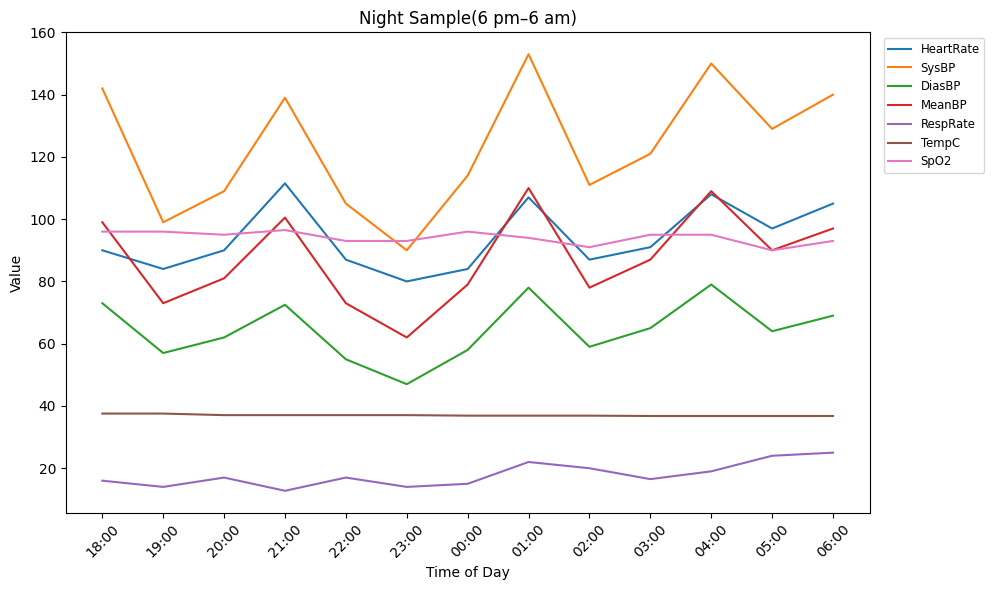

,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2
18:00,90.0,142.0,73.0,99.0,16.00,37.555555,96.0
19:00,84.0,99.0,57.0,73.0,14.00,37.555555,96.0
20:00,90.0,109.0,62.0,81.0,17.00,37.055554,95.0
21:00,111.5,139.0,72.5,100.5,12.75,37.055554,96.5
22:00,87.0,105.0,55.0,73.0,17.00,37.055554,93.0
23:00,80.0,90.0,47.0,62.0,14.00,37.055554,93.0
00:00,84.0,114.0,58.0,79.0,15.00,36.888890,96.0
01:00,107.0,153.0,78.0,110.0,22.00,36.888890,94.0
02:00,87.0,111.0,59.0,78.0,20.00,36.888890,91.0
03:00,91.0,121.0,65.0,87.0,16.50,36.777776,95.0


In [ ]:
print(truma_cohort_df['Temporal Features'][0].shape) #T:13(6pm-6am), F:['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2']

sample = truma_cohort_df['Temporal Features'][0]
feature_names = ['HeartRate', 'SysBP', 'DiasBP', 'MeanBP',
                 'RespRate', 'TempC', 'SpO2', #'Glucose', 'fio2'
                 ]
plot_nighttime_features(sample, feature_names=feature_names,
                        start_hour=18, title= "Night Sample(6 pm–6 am)")

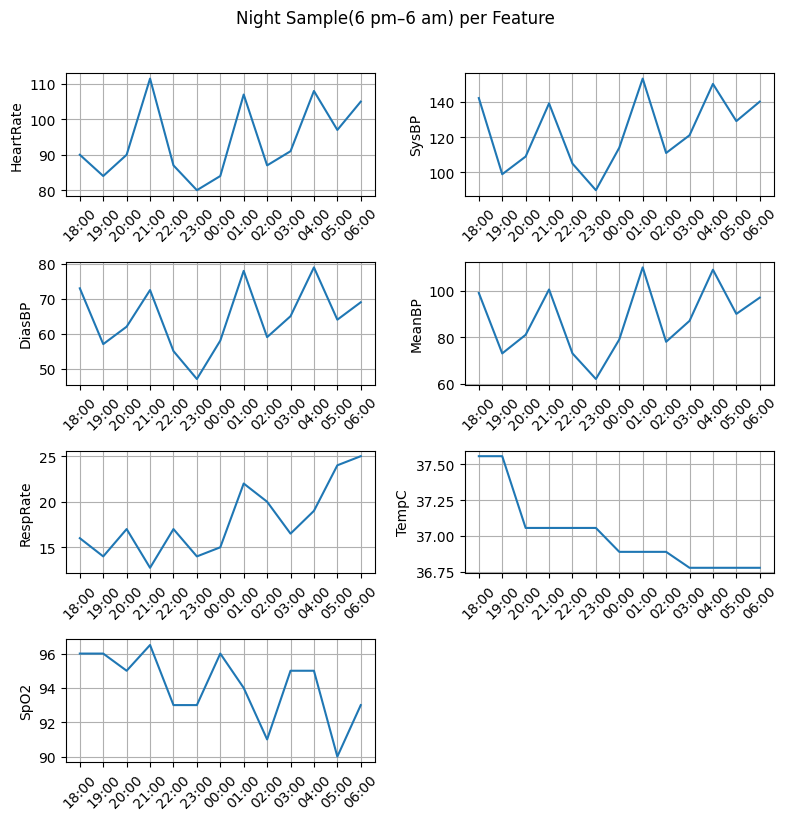

,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2
18:00,90.0,142.0,73.0,99.0,16.00,37.555555,96.0
19:00,84.0,99.0,57.0,73.0,14.00,37.555555,96.0
20:00,90.0,109.0,62.0,81.0,17.00,37.055554,95.0
21:00,111.5,139.0,72.5,100.5,12.75,37.055554,96.5
22:00,87.0,105.0,55.0,73.0,17.00,37.055554,93.0
23:00,80.0,90.0,47.0,62.0,14.00,37.055554,93.0
00:00,84.0,114.0,58.0,79.0,15.00,36.888890,96.0
01:00,107.0,153.0,78.0,110.0,22.00,36.888890,94.0
02:00,87.0,111.0,59.0,78.0,20.00,36.888890,91.0
03:00,91.0,121.0,65.0,87.0,16.50,36.777776,95.0


In [ ]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_nighttime_features_subplots(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> pd.DataFrame:
    """
    Plot each feature in its own subplot over the 13-hour window,
    arranged in a grid with `ncols` columns.
    Each subplot shows its own x-axis labels.

    Returns the DataFrame for further inspection.
    """
    T, F = sample.shape
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)

    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, col in enumerate(feature_names):
        ax = axes_flat[idx]
        ax.plot(range(T), sample_df[col], label=col)
        ax.set_ylabel(col)
        ax.grid(True)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)

    # 关闭多余的子图
    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return sample_df


plot_nighttime_features_subplots(sample, feature_names=feature_names,
                        start_hour=18, title_prefix= "Night Sample(6 pm–6 am)")

In [ ]:
# corrspondng features list: 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2', 'Glucose', 'fio2'
start_hour, T = 18,13
pd.DataFrame(truma_cohort_df.isNan[0], columns=['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2',
                                                'Glucose', 'fio2'
                                                ],
             index=[f"{(start_hour + i) % 24:02d}:00" for i in range(T)])
# False: means not nan, or have raw data
# True: is nan, data is filled

,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,Glucose,fio2
18:00,0,0,0,0,0,1,0,1,0
19:00,0,0,0,0,0,1,0,1,1
20:00,0,0,0,0,0,0,0,1,1
21:00,0,0,0,0,0,1,0,1,0
22:00,0,0,0,0,0,1,0,1,1
23:00,0,0,0,0,0,1,0,1,1
00:00,0,0,0,0,0,0,0,1,0
01:00,0,0,0,0,0,1,0,1,1
02:00,0,0,0,0,0,1,0,1,1
03:00,0,0,0,0,0,0,0,0,0


# Model

## Model Definition

### Autoencoder

In [ ]:
keras.layers.GRU

keras.src.layers.rnn.gru.GRU

In [ ]:
from keras import layers, models, Input
from keras.regularizers import l2

def Encoder_model(input_shape, name="encoder", drop_r=0.2):
    input_layer = Input(shape=input_shape)
    x = input_layer

    # LSTM Feature Extraction
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)

    # Feed Forward Part
    # FCL
    # x = layers.Dense(units=512, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(units=32, activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    # CNN
    # Feed Forward Part
    x = layers.Conv1D(filters=128, kernel_size=3, strides=1,
                      activation="relu", kernel_regularizer=l2(0.01),
                      # dilation_rate=1
                      )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, strides=2,
                      # dilation_rate=1s
                      )(x)
    x = layers.BatchNormalization()(x)

    # Output Feature Representation Vector
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    # x = layers.GlobalMaxPooling1D()(x)

    return models.Model(input_layer, x, name=name)

# def Decoder_model(T=9, F=6, feature_vector_shape=32, drop_r=0.2):
#     latent_inputs = Input(shape=feature_vector_shape[1:])
#     x = layers.RepeatVector(n=T)(latent_inputs)
#     x = layers.LSTM(units=256, return_sequences=True, kernel_regularizer=l2(0.01))(x)
#     x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(rate=drop_r)(x)
#     x = layers.Bidirectional(layers.LSTM(units=1024, return_sequences=True, kernel_regularizer=l2(0.01)))(x)
#     x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(rate=drop_r)(x)
#     dec_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)
#     return models.Model(latent_inputs, dec_output, name="decoder")


def multimodal_AutoEncoder(input_shape_li, drop_r=0.2):
    # Create input layers for each encoder
    raw_inputs = layers.Input(shape=input_shape_li[0])
    delta_inputs = layers.Input(shape=input_shape_li[1])
    inputs = [raw_inputs, delta_inputs]

    # Init Encoders
    raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
    delta_encoder = Encoder_model(input_shape_li[1], name="delta_encoder")
    encoders = [raw_encoder, delta_encoder]

    # Pass inputs through respective encoders
    embeddings = [raw_encoder(raw_inputs),
                  delta_encoder(delta_inputs)]
    # Combine the embeddings (using Concatenate)
    combined_emb = layers.Concatenate()(embeddings)
    # # Combine the embeddings (using Add)
    # combined_emb = layers.Add()(embeddings)

    # Decoder
    # feature_vector_shape=encoder.output_shape
    # latent_inputs = Input(shape=feature_vector_shape[1:])
    T, F = input_shape_li[0]
    x = layers.RepeatVector(n=T)(combined_emb)
    # x = layers.LSTM(units=1, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    decoder_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)

    # Autoencoder
    autoencoder = models.Model(inputs, decoder_output, name="autoencoder")
    return encoders, autoencoder

input_shape_li = [(9, 6), (9,6)]
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)

In [ ]:
truma_cohort_df['Temporal Features'][0].shape

(13, 7)

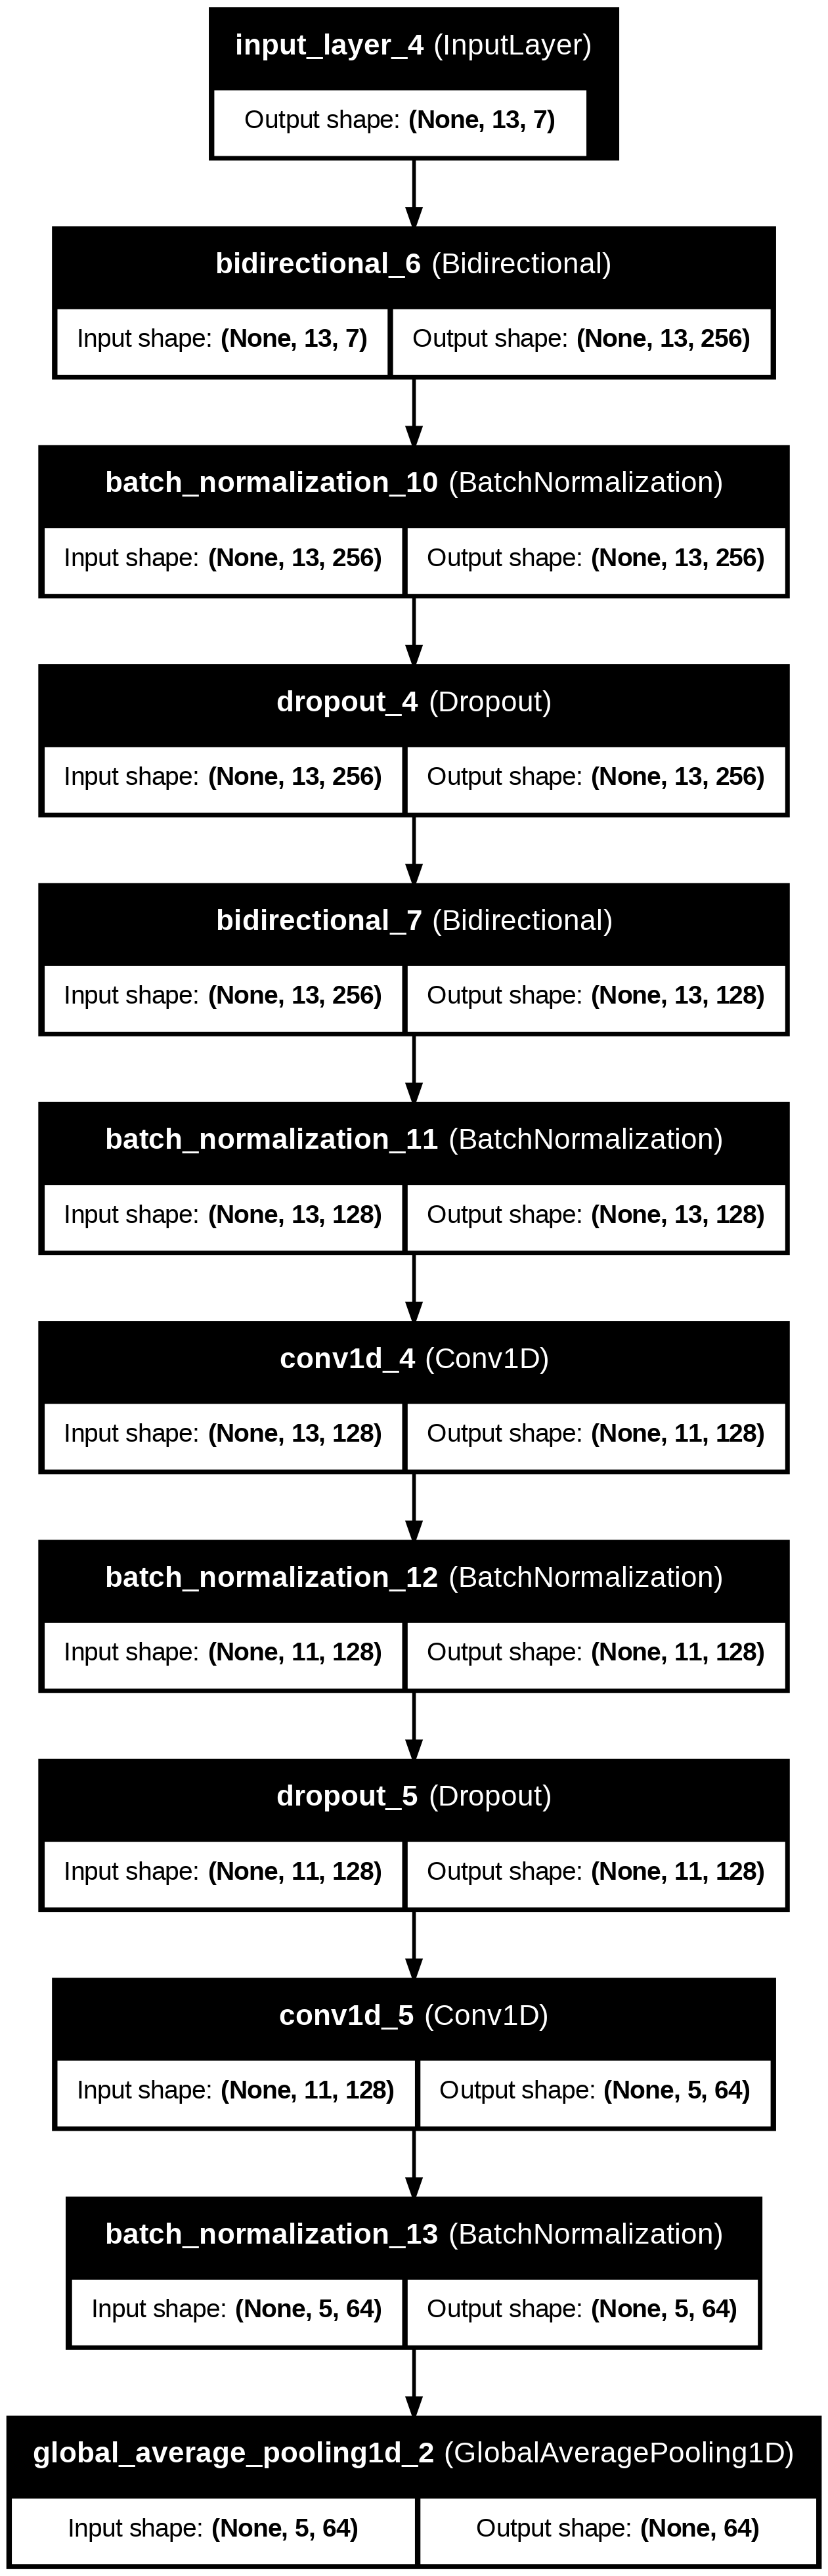

In [ ]:
input_shape_li = [(13, 7), (13,7)]
# encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
keras.utils.plot_model(raw_encoder, show_shapes=True, show_layer_names=True)

Model: "night_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 9, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 9, 256)         │       104,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 9, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 9, 128)         │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,320 (1.16 MB)

 Trainable params: 303,168 (1.16 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 9, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 9, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    304,320 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    304,320 │ input_layer_6[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 9, 128)    │          0 │ concatenate_1[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 9, 128)    │     74,496 │ repeat_vector_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 128)    │        512 │ bidirectional_12… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 9, 256)    │    198,144 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 256)    │      1,024 │ bidirectional_13… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 9, 6)      │      1,542 │ batch_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 884,358 (3.37 MB)

 Trainable params: 881,286 (3.36 MB)

 Non-trainable params: 3,072 (12.00 KB)

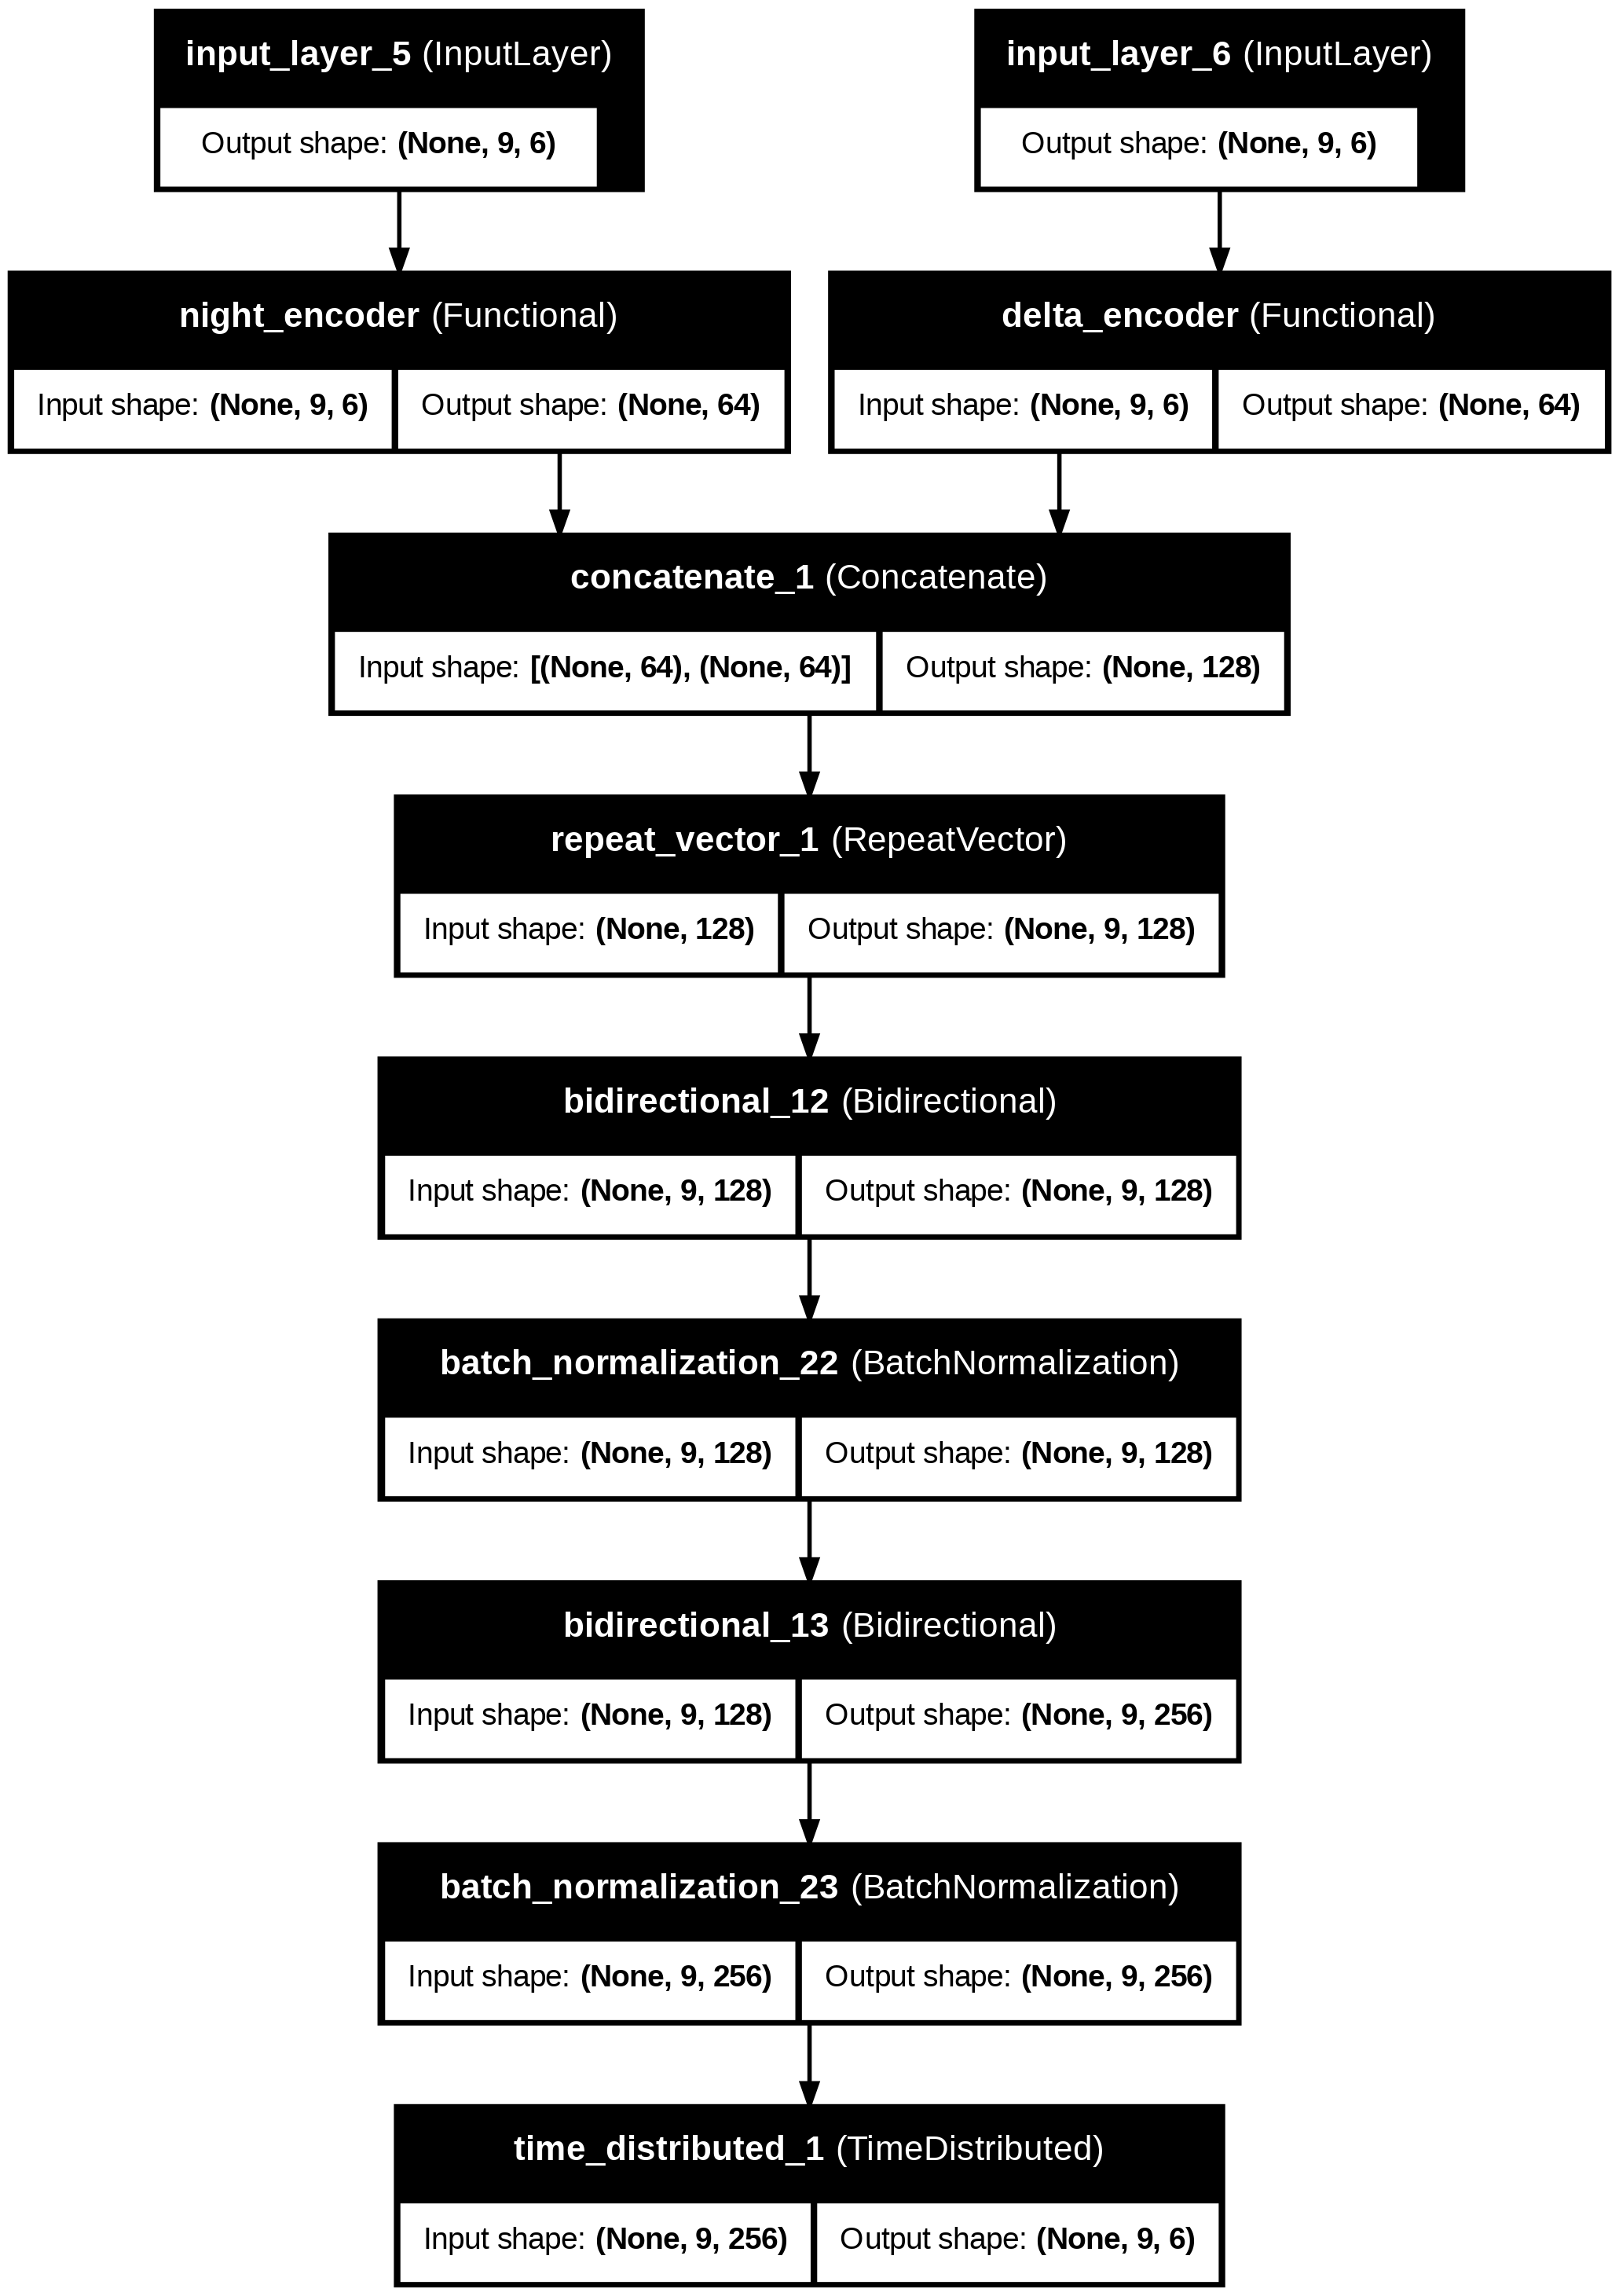

In [ ]:
# Instantiate the models
input_shape_li = [(9, 6), (9,6)]
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li)

# # Print summary of the autoencoder model
encoders[0].summary()
# encoders[1].summary()
autoencoder.summary()

keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True)

### Classifier

## Custom Fit and Loss Functions

In [ ]:
def masked_mae(y_true, y_pred, mask, alpha=1.0):
    """
    Weighted MAE for Masked-AE.
    alpha = mask_weight_para in [0, 1]:
        1.0 → loss from masked positions only
        0.5 → half masked, half visible
        0.0 → all positions equally
    """
    # element-wise L1 error
    err = tf.abs(y_true - y_pred)

    # visible = 1, masked = 0  ▸ convert to float32
    mask = tf.cast(mask, tf.float32)

    # build weights: w = (1-alpha)·visible + alpha·masked
    weights = (1.0 - alpha) * mask + alpha * (1.0 - mask)

    # masked mean
    loss = tf.reduce_sum(err * weights) / tf.reduce_sum(weights)
    return loss


In [ ]:
class MaskedReconstructionFit(tf.keras.Model):
    def __init__(self, model, alpha=1.0):
        super(MaskedReconstructionFit, self).__init__()
        self.model = model
        self.alpha = alpha         # mask_weight_para
        # self.loss_fn = weight_mae
        # self.test_loss_fn = tf.keras.losses.MeanAbsoluteError()
        self.metric = tf.keras.metrics.MeanAbsoluteError()

    def compile(self, optimizer, metrics=None, **kwargs):
        super().compile(optimizer=optimizer, metrics=metrics, **kwargs)

    def train_step(self, data):
        (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
        mask = tf.cast(mask, tf.float32)
        masked_x = x * mask  # Apply the mask to the input
        # masked_x_delta = x_delta * mask
        # tf.print("Masked input (masked_x):", masked_x, summarize=-1)  # summarize=-1 prints the full tensor

        with tf.GradientTape() as tape:
            x_hat = self.model([masked_x, x_delta], training=True)
            loss  = masked_mae(x, x_hat, mask, self.alpha)

        # Compute gradients and update weights
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Update the reconstruction loss metric
        self.metric.update_state(x, x_hat)
        # Return the reconstruction loss as the only metric
        return {"loss": loss, "global_MAE": self.metric.result()}



    def test_step(self, data):
        (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
        mask = tf.cast(mask, tf.float32)
        x_visible = x * mask              # zero-out masked positions

        x_hat = self.model([x_visible, x_delta], training=False)
        loss  = masked_mae(x, x_hat, mask, self.alpha)

        # Update the reconstruction loss metric
        self.metric.update_state(x, x_hat)
        # ---- build log dict (TOP-LEVEL keys!) ----
        return {"loss": loss, "global_MAE":self.metric.result()}


## Evaluation and Learning Curve Plotting Function

In [ ]:
def plot_learning_curves(training_history, log_history=None, name='', metric_name_li=[], init_index=0):
    """
    Plots the learning curves for training and validation loss/accuracy.

    Parameters:
    - training_history: The history object returned from model.fit.

    Returns:
    - None (Displays the plots).
    """
    if log_history is not None:
        history_data = log_history
    else:
        history_data = training_history.history

    # Loop through each metric in the history
    if len(metric_name_li) == 0:
      for metric_name in history_data.keys():
          if 'val' not in metric_name:
              metric_name_li.append(metric_name)

    for metric_name in metric_name_li:
            epochs = range(init_index+1, len(history_data[metric_name]) + 1)
            # print(len(epochs), len(history_data[metric_name][init_index:]))

            # Create a new figure for each metric
            metric_fig = plt.figure(figsize=(4, 3))
            plt.plot(epochs, history_data[metric_name][init_index:], label=f'Training {metric_name}')
            plt.plot(epochs, history_data[f'val_{metric_name}'][init_index:], label=f'Validation {metric_name}')

            # Formatting the plot
            plt.title(f'{metric_name.capitalize()}-{name}')
            plt.xlabel('Epochs')
            plt.ylabel(metric_name.capitalize())
            plt.legend()
            plt.grid(True)

            # Display the plot
            # metric_fig.tight_layout()
            metric_fig.show()
    return

# plot_learning_curves(history, init_index=5)

## Save Model

In [ ]:
from tensorflow.keras.models import save_model

def save_models(encoders, autoencoder, save_dir):
    """
    Saves encoders (list of two models) and autoencoder model to the given directory.

    Parameters:
    - encoders (list): A list containing two Keras models (encoder models).
    - autoencoder (Model): The main autoencoder model.
    - save_dir (str): Directory path where models will be saved.

    Returns:
    - None (saves models to disk).
    """

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save encoder models
    save_model(encoders[0], os.path.join(save_dir, "encoder_1.h5"))
    save_model(encoders[1], os.path.join(save_dir, "encoder_2.h5"))

    # Save autoencoder model
    save_model(autoencoder, os.path.join(save_dir, "autoencoder.h5"))

    print(f"Models saved in: {save_dir}")


from tensorflow.keras.models import load_model
def load_models(load_dir, load_autoencoder=True):
    """
    Loads two encoder models and optionally an autoencoder model from the specified directory.

    Parameters:
    - load_dir (str): Directory path where models are saved.
    - load_autoencoder (bool): Whether to load the autoencoder model (default is True).

    Returns:
    - encoders (list): A list containing two loaded encoder models.
    - autoencoder (Model or None): The loaded autoencoder model if `load_autoencoder=True`, else None.
    """

    # Ensure the directory exists
    if not os.path.exists(load_dir):
        raise FileNotFoundError(f"Directory {load_dir} does not exist. Please check the path.")

    # Load encoder models
    encoder_1 = load_model(os.path.join(load_dir, "encoder_1.h5"))
    encoder_2 = load_model(os.path.join(load_dir, "encoder_2.h5"))

    encoders = [encoder_1, encoder_2]

    # Load autoencoder model if specified
    autoencoder = None
    if load_autoencoder:
        autoencoder = load_model(os.path.join(load_dir, "autoencoder.h5"))
        print(f"Autoencoder loaded successfully from: {load_dir}")

    print(f"Encoders loaded successfully from: {load_dir}")

    return encoders, autoencoder

# Data Preprocess

## Sampling with mask strategy

In [ ]:
from sklearn.utils import shuffle

def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked
    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    # np.random.seed(seed)
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask

def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (seq_length, feat_dim) numpy array of features corresponding to a single sample
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at a certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked squences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)
    Returns:
        boolean numpy array with the same shape as X, with 0s at places where a feature should be masked
    """
    # np.random.seed(seed)
    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = np.ones(X.shape, dtype=bool)
            for m in range(X.shape[1]):  # feature dimension
                if exclude_feats is None or m not in exclude_feats:
                    mask[:, m] = geom_noise_mask_single(X.shape[0], lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask = np.tile(np.expand_dims(geom_noise_mask_single(X.shape[0], lm, masking_ratio), 1), X.shape[1])
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = np.random.choice(np.array([True, False]), size=X.shape, replace=True,
                                    p=(1 - masking_ratio, masking_ratio))
        else:
            mask = np.tile(np.random.choice(np.array([True, False]), size=(X.shape[0], 1), replace=True,
                                            p=(1 - masking_ratio, masking_ratio)), X.shape[1])

    return mask

def Gen_Mask(X, r=0.15, lm=2):
  '''
  Gen mask Matrix for a given training sample
  '''
  M = noise_mask(X, r, lm, mode='separate', distribution='geometric', exclude_feats=None)
  M = np.where(M, 1, 0)
  return M

def Gen_Masked_data(X, M):
  '''
  Gen mask input Matrix as target for lossfunction for training process
  '''
  Y = np.multiply(X, np.subtract(1, M))
  return Y

def Gen_Unmask_Data(X, M):
  '''
  Gen un-mask Matrix for training process
  '''
  X = np.multiply(X,M)
  return X

In [ ]:
import pandas as pd
from sklearn.utils import resample

def oversample_binary_df(df: pd.DataFrame, target_column: str, random_state: int = 66) -> pd.DataFrame:
    """
    Perform oversampling on the minority class to balance a binary classification dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    target_column : str
        Name of the binary label column.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Balanced dataframe with equal number of samples from each class.
    """
    # Split majority and minority
    df_majority = df[df[target_column] == 0]
    df_minority = df[df[target_column] == 1]

    # Resample
    df_minority_oversampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=random_state
    )

    # Combine and shuffle
    df_balanced = pd.concat([df_majority, df_minority_oversampled])
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return df_balanced


## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def fit_minmax_scaler(train_X: np.ndarray, eps: float = 0.05) -> MinMaxScaler:
    """
    Fit a MinMaxScaler to training data only.

    Parameters
    ----------
    train_X : np.ndarray
        Training data of shape (N, T, F).
    eps : float
        Lower bound of the scaled range. Default is 0.05.

    Returns
    -------
    scaler : MinMaxScaler
        Fitted scaler object.
    """
    _, _, F = train_X.shape
    train_flat = train_X.reshape(-1, F)
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    scaler.fit(train_flat)
    return scaler

def normalize_with_scaler(X: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """
    Normalize input data using a fitted MinMaxScaler.

    Supports both (N, T, F) and (T, F) shaped arrays.

    Parameters
    ----------
    X : np.ndarray
        Input array with shape (N, T, F) or (T, F).
    scaler : MinMaxScaler
        Previously fitted scaler.

    Returns
    -------
    X_norm : np.ndarray
        Normalized array with same shape as input.
    """
    original_shape = X.shape
    if X.ndim == 3:
        N, T, F = X.shape
        flat = X.reshape(-1, F)
        flat_norm = scaler.transform(flat)
        return flat_norm.reshape(N, T, F)
    elif X.ndim == 2:
        T, F = X.shape
        flat_norm = scaler.transform(X)
        return flat_norm.reshape(T, F)
    else:
        raise ValueError("Input must have shape (N, T, F) or (T, F).")


def denormalize_with_scaler(X_norm: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """
    Inverse-transform normalized data using a fitted MinMaxScaler.

    Supports both (N, T, F) and (T, F) shaped arrays.

    Parameters
    ----------
    X_norm : np.ndarray
        Normalized array of shape (N, T, F) or (T, F).
    scaler : MinMaxScaler
        Previously fitted scaler.

    Returns
    -------
    X_raw : np.ndarray
        De-normalized array of same shape as input.
    """
    original_shape = X_norm.shape
    if X_norm.ndim == 3:
        N, T, F = X_norm.shape
        flat_norm = X_norm.reshape(-1, F)
        flat_raw = scaler.inverse_transform(flat_norm)
        return flat_raw.reshape(N, T, F)
    elif X_norm.ndim == 2:
        T, F = X_norm.shape
        flat_raw = scaler.inverse_transform(X_norm)
        return flat_raw.reshape(T, F)
    else:
        raise ValueError("Input must have shape (N, T, F) or (T, F).")


## Preprocess 2 Night data

In [ ]:
def generate_2night_data(df):
    df = df.reset_index()
    # Extract previous day data
    previous_day_df = df.shift(1).iloc[1:]
    previous_day_df['Night'] = previous_day_df['Night'].astype(int)

    df = df.iloc[1:]
    df['PreviousNight'] = previous_day_df['Night']

    # Generate 2 night
    TwoNight_df = pd.DataFrame()
    TwoNight_df['subject_id'] = df.subject_id
    TwoNight_df['hadm_id'] = df.hadm_id
    TwoNight_df['Night'] = df.apply(lambda row: f"{row.PreviousNight}--{row.Night}", axis=1)
    TwoNight_df['PreviousNight'] = previous_day_df['Temporal Features']
    TwoNight_df['CurrentNight'] = df['Temporal Features']
    TwoNight_df['Delta'] = TwoNight_df.apply(
        lambda row: row.CurrentNight - row.PreviousNight
        if isinstance(row["PreviousNight"], np.ndarray) else np.nan
        , axis=1
        )
    if 'Label' in df.columns:
        TwoNight_df['Label'] = df.Label
        TwoNight_df['Fold'] = df.Fold

    TwoNight_df = TwoNight_df.dropna()

    # TwoNight_df['InputFeatures'] = TwoNight_df.apply(
    #     lambda row: np.concatenate((row["CurrentNight"], row['Delta']), axis=1)
    #     if isinstance(row["Delta"], np.ndarray) else np.nan
    #     , axis=1
    # )
    # TwoNight_df['InputFeatures'] = TwoNight_df['CurrentNight']

    # # Drop duplicate data
    # TwoNight_df.drop(['PreviousNight', #'CurrentNight', #'Delta'
    #                   ], axis=1, inplace=True)

    return TwoNight_df

In [ ]:
from imblearn.over_sampling import RandomOverSampler

def random_oversample_dual_input(
    X1: np.ndarray,
    X2: np.ndarray,
    y:  np.ndarray,
    random_state: int | None = 42,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Randomly oversample a dual-input (multi-modal) dataset so each class reaches
    the size of the majority class.

    Parameters
    ----------
    X1, X2 : np.ndarray
        Two input tensors with identical first-dimension length, shapes
        (N, T, F). They are flattened & concatenated internally.
    y : np.ndarray
        Label vector of shape (N,).
    random_state : int | None, optional
        Seed for reproducibility (default 42).

    Returns
    -------
    X1_os, X2_os, y_os : np.ndarray
        Oversampled copies of the two inputs and labels, shapes
        (N_new, T, F) and (N_new,).
    """
    # --- Sanity check ------------------------------------------------------
    assert X1.shape == X2.shape, "X1 and X2 must share (N, T, F) shape"
    N, T, F = X1.shape

    # --- 1. Flatten & concatenate ------------------------------------------
    X_concat = np.hstack([X1.reshape(N, -1), X2.reshape(N, -1)])  # (N, 2·T·F)

    # --- 2. Random oversampling -------------------------------------------
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X_concat, y)

    # --- 3. Split & reshape back ------------------------------------------
    split = T * F
    X1_os = X_res[:, :split].reshape(-1, T, F)
    X2_os = X_res[:, split:].reshape(-1, T, F)
    return X1_os, X2_os, y_res

In [ ]:
dataset_df = truma_cohort_df[['subject_id', 'hadm_id', 'Night', 'Temporal Features','Label', 'Fold']].sort_values(['hadm_id', 'Night'])
dataset_df['Night']= dataset_df.Night.astype(int)
NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)

# Drop non Continuous Day
isContinuousDay = NightAndDelta_dataset["Night"].apply(
    lambda x: (lambda a, b: b - a == 1)(*map(int, x.split('--')))
)

NightAndDelta_dataset_Continuous = NightAndDelta_dataset[isContinuousDay]

NightAndDelta_dataset_Continuous.head()

/tmp/ipython-input-547857484.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)


subject_id  hadm_id Night  \
hadm_id                                
100011  1       87977   100011  2--3   
        2       87977   100011  3--4   
        3       87977   100011  4--5   
        4       87977   100011  5--6   
100035  1       48539   100035  4--5   

                                               PreviousNight  \
hadm_id                                                        
100011  1  [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
        2  [[109.33333333333333, 158.33333333333334, 82.6...   
        3  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        4  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100035  1  [[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...   

                                                CurrentNight  \
hadm_id                                                        
100011  1  [[109.33333333333333, 158.33333333333334, 82.6...   
        2  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        3  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
        4  [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   
100035  1  [[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...   

                                                       Delta  Label  Fold  
hadm_id                                                                    
100011  1  [[21.33333333333333, -8.666666666666657, 0.666...      0     4  
        2  [[-12.333333333333329, -15.333333333333343, -1...      0     4  
        3  [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...      0     4  
        4  [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...      1     4  
100035  1  [[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...      1     2

In [ ]:
# 1.  Ensure the second level never exceeds 999  (you said it is 0 – 295)
assert NightAndDelta_dataset_Continuous.index.get_level_values(1).max() < 1_000

# 2.  Collapse the two levels:
NightAndDelta_dataset_Continuous.index = (
    NightAndDelta_dataset_Continuous.index.get_level_values(0) * 1_000   # reserve three digits
    + NightAndDelta_dataset_Continuous.index.get_level_values(1)
).astype("int64")          # → Int64Index like 100001001

# 3.  (optional) give the new single‐level index a name
NightAndDelta_dataset_Continuous.index.name = "instence_id"
NightAndDelta_dataset_Continuous

,subject_id,hadm_id,Night,PreviousNight,CurrentNight,Delta,Label,Fold
instence_id,,,,,,,,
100011001,87977,100011,2--3,"[[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...","[[109.33333333333333, 158.33333333333334, 82.6...","[[21.33333333333333, -8.666666666666657, 0.666...",0,4
100011002,87977,100011,3--4,"[[109.33333333333333, 158.33333333333334, 82.6...","[[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...","[[-12.333333333333329, -15.333333333333343, -1...",0,4
100011003,87977,100011,4--5,"[[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...","[[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...","[[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...",0,4
100011004,87977,100011,5--6,"[[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...","[[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...","[[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...",1,4
100035001,48539,100035,4--5,"[[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...","[[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...","[[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...",1,2
...,...,...,...,...,...,...,...,...
199976008,26198,199976,9--10,"[[83.5, 168.75, 60.25, 95.5, 16.5, 38.66666581...","[[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...","[[-1.5, 35.75, 3.75, 15.666648864746094, 7.5, ...",0,0
199976009,26198,199976,10--11,"[[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...","[[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...","[[7.0, -48.5, -8.5, -24.166648864746094, -6.0,...",0,0
199976010,26198,199976,11--12,"[[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...","[[73.0, 155.5, 55.0, 84.6666488647461, 19.0, 3...","[[-16.0, -0.5, -0.5, -2.3333511352539062, 1.0,...",0,0


### Sample

In [ ]:
df_100011 = dataset_df[dataset_df['hadm_id']==100011]
display(df_100011)
NightAndDelta_dataset_Continuous[NightAndDelta_dataset_Continuous['hadm_id'] == 100011]

,subject_id,hadm_id,Night,Temporal Features,Label,Fold
6821,87977,100011,2,"[[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...",0,4
6822,87977,100011,3,"[[109.33333333333333, 158.33333333333334, 82.6...",0,4
6823,87977,100011,4,"[[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...",0,4
6824,87977,100011,5,"[[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...",0,4
6825,87977,100011,6,"[[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...",1,4


,subject_id,hadm_id,Night,PreviousNight,CurrentNight,Delta,Label,Fold
instence_id,,,,,,,,
100011001,87977,100011,2--3,"[[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...","[[109.33333333333333, 158.33333333333334, 82.6...","[[21.33333333333333, -8.666666666666657, 0.666...",0,4
100011002,87977,100011,3--4,"[[109.33333333333333, 158.33333333333334, 82.6...","[[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...","[[-12.333333333333329, -15.333333333333343, -1...",0,4
100011003,87977,100011,4--5,"[[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...","[[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...","[[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...",0,4
100011004,87977,100011,5--6,"[[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...","[[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...","[[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...",1,4


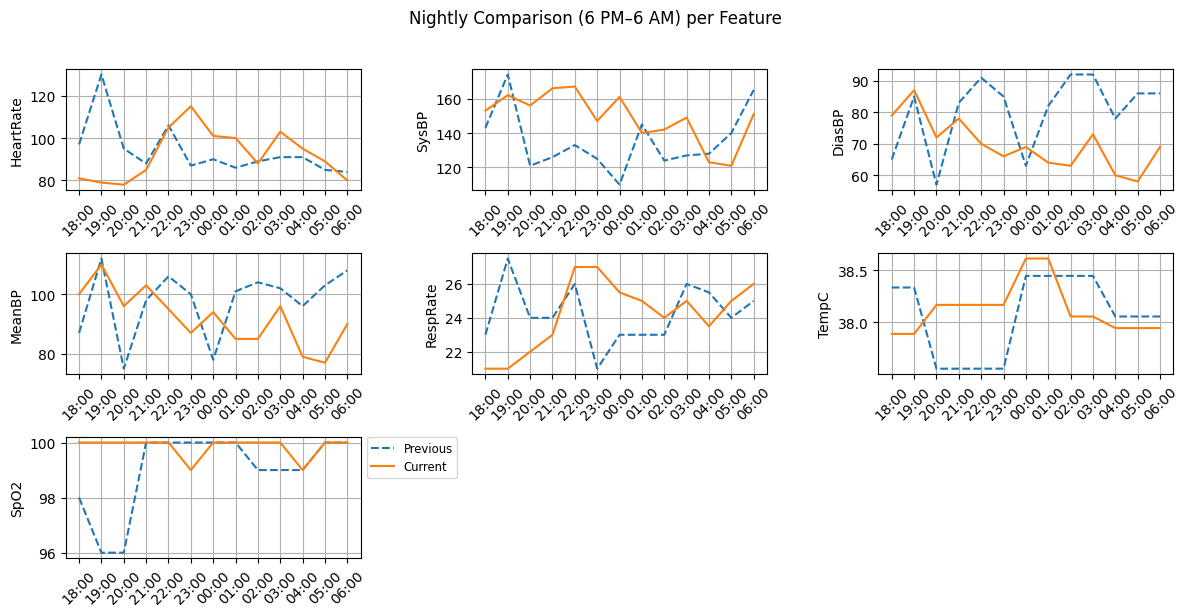

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_two_nights_features_subplots(
    sample_prev: np.ndarray,
    sample_curr: np.ndarray,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    在每个子图中对比前一夜和当夜同一特征的时序：
    - sample_prev、sample_curr：形状均为 (T, F) 的数组
    - feature_names：长度为 F 的特征名列表
    - start_hour：开始小时（如 18 表示 18:00）
    - ncols：子图每行列数
    - title_prefix：整体标题前缀

    返回两个 DataFrame (df_prev, df_curr)，方便后续检查。
    """
    # 校验输入
    T, F = sample_curr.shape
    assert sample_prev.shape == sample_curr.shape, "两个样本的形状必须相同 (T, F)"

    # 构造时间标签
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # 构造 DataFrame
    df_prev = pd.DataFrame(sample_prev, columns=feature_names, index=hour_labels)
    df_curr = pd.DataFrame(sample_curr, columns=feature_names, index=hour_labels)

    # 子图布局
    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, feature in enumerate(feature_names):
        ax = axes_flat[idx]
        # 绘制前一夜（虚线）和当夜（实线）
        ax.plot(range(T), df_prev[feature], label="Previous", linestyle="--")
        ax.plot(range(T), df_curr[feature], label="Current",   linestyle="-")
        ax.set_ylabel(feature)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)
        ax.grid(True)

    ax.legend(
        ["Previous", "Current"],
        loc="upper left",
        fontsize="small",
        # bbox_to_anchor 的第一个参数 >1 表示在轴外右侧
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return df_prev, df_curr

# usage sample
idx = 2
sample_prev = NightAndDelta_dataset_Continuous.iloc[idx]['PreviousNight']
sample_curr = NightAndDelta_dataset_Continuous.iloc[idx]['CurrentNight']
df_prev, df_curr = plot_two_nights_features_subplots(
    sample_prev, sample_curr, feature_names,
    start_hour=18, ncols=3,
    title_prefix="Nightly Comparison (6 PM–6 AM)"
)


In [ ]:
def generate_2night_data(df):
    df = df.reset_index()
    # Extract previous day data
    previous_day_df = df.shift(1).iloc[1:]
    previous_day_df['Night'] = previous_day_df['Night'].astype(int)

    df = df.iloc[1:]
    df['PreviousNight'] = previous_day_df['Night']

    # Generate 2 night
    TwoNight_df = pd.DataFrame()
    TwoNight_df['subject_id'] = df.subject_id
    TwoNight_df['hadm_id'] = df.hadm_id
    TwoNight_df['Night'] = df.apply(lambda row: f"{row.PreviousNight}--{row.Night}", axis=1)
    TwoNight_df['PreviousNight'] = previous_day_df['Temporal Features']
    TwoNight_df['CurrentNight'] = df['Temporal Features']
    TwoNight_df['Delta'] = TwoNight_df.apply(
        lambda row: row.CurrentNight - row.PreviousNight
        if isinstance(row["PreviousNight"], np.ndarray) else np.nan
        , axis=1
        )
    if 'Label' in df.columns:
        TwoNight_df['Label'] = df.Label
    if 'Fold' in df.columns:
        TwoNight_df['Fold'] = df.Fold

    TwoNight_df = TwoNight_df.dropna()

    # TwoNight_df['InputFeatures'] = TwoNight_df.apply(
    #     lambda row: np.concatenate((row["CurrentNight"], row['Delta']), axis=1)
    #     if isinstance(row["Delta"], np.ndarray) else np.nan
    #     , axis=1
    # )
    # TwoNight_df['InputFeatures'] = TwoNight_df['CurrentNight']

    # # Drop duplicate data
    # TwoNight_df.drop(['PreviousNight', #'CurrentNight', #'Delta'
    #                   ], axis=1, inplace=True)

    return TwoNight_df

## training

In [ ]:
dataset_df = truma_cohort_df[['subject_id', 'hadm_id', 'Night', 'Temporal Features',
                              'Fold']
                             ].sort_values(['hadm_id', 'Night'])
NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)

# Drop non Continuous Day
isContinuousDay = NightAndDelta_dataset["Night"].apply(
    lambda x: (lambda a, b: b - a == 1)(*map(int, x.split('--')))
)
NightAndDelta_dataset_Continuous = NightAndDelta_dataset[isContinuousDay]

NightAndDelta_dataset_Continuous.head()

/tmp/ipython-input-3741074339.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)


subject_id  hadm_id   Night  \
hadm_id                                  
100011  1       87977   100011  2--003   
        2       87977   100011  3--004   
        3       87977   100011  4--005   
        4       87977   100011  5--006   
100035  1       48539   100035  4--005   

                                               PreviousNight  \
hadm_id                                                        
100011  1  [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
        2  [[109.33333333333333, 158.33333333333334, 82.6...   
        3  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        4  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100035  1  [[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...   

                                                CurrentNight  \
hadm_id                                                        
100011  1  [[109.33333333333333, 158.33333333333334, 82.6...   
        2  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        3  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
        4  [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   
100035  1  [[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...   

                                                       Delta  Fold  
hadm_id                                                             
100011  1  [[21.33333333333333, -8.666666666666657, 0.666...     4  
        2  [[-12.333333333333329, -15.333333333333343, -1...     4  
        3  [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...     4  
        4  [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...     4  
100035  1  [[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...     2

In [ ]:
# 1.  Ensure the second level never exceeds 999  (you said it is 0 – 295)
assert NightAndDelta_dataset_Continuous.index.get_level_values(1).max() < 1_000

# 2.  Collapse the two levels:
NightAndDelta_dataset_Continuous.index = (
    NightAndDelta_dataset_Continuous.index.get_level_values(0) * 1_000   # reserve three digits
    + NightAndDelta_dataset_Continuous.index.get_level_values(1)
).astype("int64")          # → Int64Index like 100001001

# 3.  (optional) give the new single‐level index a name
NightAndDelta_dataset_Continuous.index.name = "instence_id"
NightAndDelta_dataset_Continuous

,subject_id,hadm_id,Night,PreviousNight,CurrentNight,Delta,Fold
instence_id,,,,,,,
100011001,87977,100011,2--003,"[[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...","[[109.33333333333333, 158.33333333333334, 82.6...","[[21.33333333333333, -8.666666666666657, 0.666...",4
100011002,87977,100011,3--004,"[[109.33333333333333, 158.33333333333334, 82.6...","[[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...","[[-12.333333333333329, -15.333333333333343, -1...",4
100011003,87977,100011,4--005,"[[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...","[[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...","[[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...",4
100011004,87977,100011,5--006,"[[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...","[[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...","[[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...",4
100035001,48539,100035,4--005,"[[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...","[[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...","[[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...",2
...,...,...,...,...,...,...,...
199976008,26198,199976,9--010,"[[83.5, 168.75, 60.25, 95.5, 16.5, 38.66666581...","[[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...","[[-1.5, 35.75, 3.75, 15.666648864746094, 7.5, ...",0
199976009,26198,199976,10--011,"[[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...","[[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...","[[7.0, -48.5, -8.5, -24.166648864746094, -6.0,...",0
199976010,26198,199976,11--012,"[[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...","[[73.0, 155.5, 55.0, 84.6666488647461, 19.0, 3...","[[-16.0, -0.5, -0.5, -2.3333511352539062, 1.0,...",0


## testing

In [ ]:
# truma_dataset_df = truma_records[['subject_id', 'hadm_id', 'Night', 'Temporal Features',]].sort_values(['hadm_id', 'Night'])
# truma_NightAndDelta_dataset = truma_dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)

# # Drop non Continuous Day
# truma_isContinuousDay = truma_NightAndDelta_dataset["Night"].apply(
#     lambda x: (lambda a, b: b - a == 1)(*map(int, x.split('--')))
# )
# truma_NightAndDelta_dataset_Continuous = truma_NightAndDelta_dataset[truma_isContinuousDay]

# # Ensure the second level never exceeds 999  (you said it is 0 – 295)
# assert truma_NightAndDelta_dataset_Continuous.index.get_level_values(1).max() < 1_000
# # Collapse the two levels:
# truma_NightAndDelta_dataset_Continuous.index = (
#     truma_NightAndDelta_dataset_Continuous.index.get_level_values(0) * 1_000   # reserve three digits
#     + truma_NightAndDelta_dataset_Continuous.index.get_level_values(1)
# ).astype("int64")          # → Int64Index like 100001001
# # (optional) give the new single‐level index a name
# truma_NightAndDelta_dataset_Continuous.index.name = "instence_id"
# truma_NightAndDelta_dataset_Continuous

### Sample

In [ ]:
df_100132 = dataset_df[dataset_df['hadm_id']==100132]
display(df_100132)
NightAndDelta_dataset_Continuous[NightAndDelta_dataset_Continuous['hadm_id'] == 100132]

,subject_id,hadm_id,Night,Temporal Features,Fold
0,19984,100132,002,"[[90.0, 142.0, 73.0, 99.0, 16.0, 37.5555547078...",3
1,19984,100132,003,"[[97.0, 129.0, 61.0, 86.0, 20.0, 36.2222205268...",3
2,19984,100132,004,"[[68.0, 87.0, 47.0, 60.33330154418945, 15.0, 3...",3
3,19984,100132,005,"[[96.0, 133.0, 71.0, 91.6667022705078, 22.0, 3...",3
4,19984,100132,006,"[[107.0, 188.0, 85.0, 119.33300018310548, 23.0...",3


,subject_id,hadm_id,Night,PreviousNight,CurrentNight,Delta,Fold
instence_id,,,,,,,
100132001,19984,100132,2--003,"[[90.0, 142.0, 73.0, 99.0, 16.0, 37.5555547078...","[[97.0, 129.0, 61.0, 86.0, 20.0, 36.2222205268...","[[7.0, -13.0, -12.0, -13.0, 4.0, -1.3333341810...",3
100132002,19984,100132,3--004,"[[97.0, 129.0, 61.0, 86.0, 20.0, 36.2222205268...","[[68.0, 87.0, 47.0, 60.33330154418945, 15.0, 3...","[[-29.0, -42.0, -14.0, -25.666698455810547, -5...",3
100132003,19984,100132,4--005,"[[68.0, 87.0, 47.0, 60.33330154418945, 15.0, 3...","[[96.0, 133.0, 71.0, 91.6667022705078, 22.0, 3...","[[28.0, 46.0, 24.0, 31.333400726318345, 7.0, -...",3
100132004,19984,100132,5--006,"[[96.0, 133.0, 71.0, 91.6667022705078, 22.0, 3...","[[107.0, 188.0, 85.0, 119.33300018310548, 23.0...","[[11.0, 55.0, 14.0, 27.666297912597685, 1.0, 0...",3


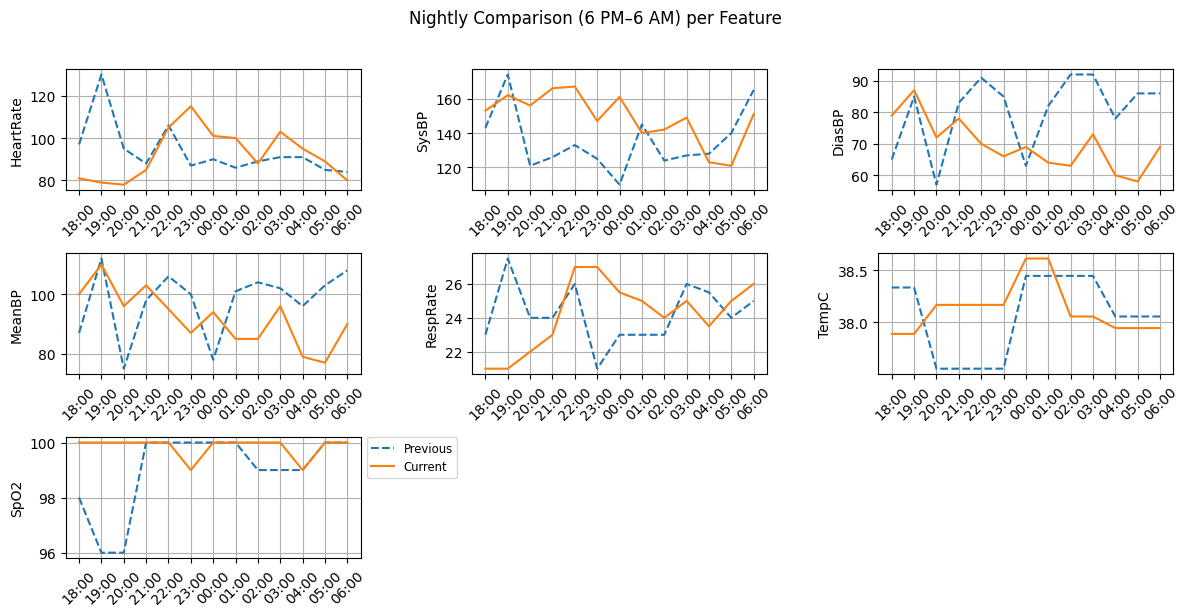

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_two_nights_features_subplots(
    sample_prev: np.ndarray,
    sample_curr: np.ndarray,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    In each subplot, compare the time series of the same feature between the previous night and the current night:
    - sample_prev, sample_curr: arrays of shape (T, F)
    - feature_names: a list of feature names of length F
    - start_hour: starting hour (e.g., 18 means 18:00)
    - ncols: number of columns per row of subplots
    - title_prefix: prefix for the overall title

    Return two DataFrames (df_prev, df_curr) for convenient subsequent inspection.
    """
    # Validate input
    T, F = sample_curr.shape
    assert sample_prev.shape == sample_curr.shape, "The two samples must have the same shape (T, F)"

    # Build time labels
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # Build DataFrame
    df_prev = pd.DataFrame(sample_prev, columns=feature_names, index=hour_labels)
    df_curr = pd.DataFrame(sample_curr, columns=feature_names, index=hour_labels)

    # Subplot layout
    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, feature in enumerate(feature_names):
        ax = axes_flat[idx]
        # Plot previous night (dashed line) and current night (solid line)
        ax.plot(range(T), df_prev[feature], label="Previous", linestyle="--")
        ax.plot(range(T), df_curr[feature], label="Current", linestyle="-")
        ax.set_ylabel(feature)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)
        ax.grid(True)

    ax.legend(
        ["Previous", "Current"],
        loc="upper left",
        fontsize="small",
        # The first parameter of bbox_to_anchor > 1 means placing the legend outside to the right
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()


    return df_prev, df_curr

# usage sample
idx = 2
sample_prev = NightAndDelta_dataset_Continuous.iloc[idx]['PreviousNight']
sample_curr = NightAndDelta_dataset_Continuous.iloc[idx]['CurrentNight']
df_prev, df_curr = plot_two_nights_features_subplots(
    sample_prev, sample_curr, feature_names,
    start_hour=18, ncols=3,
    title_prefix="Nightly Comparison (6 PM–6 AM)"
)


# Unify MAE pretrain model on Trauma

## training

**Goal: Set a “passing line” for yourself**

* **Data range.** After min-max scaling to (0.05 – 1.00), the dynamic range is $R = 0.95$.

* **Do-nothing baseline.** Always output the global mean (0.525).

  * For a roughly uniform distribution, this gives
  $$
  \text{MAE}_{\text{baseline}} \approx \tfrac{R}{4} \approx 0.24,\qquad
  $$
    
  * Any model with **MAE ≪ 0.24** and **MSE ≪ 0.075** beats the “do-nothing” baseline.

* **Practical target range (full reconstruction, no sensor noise).**

  * **MAE:** 0.01 – 0.03 (≈ 1 % – 3 % absolute error)

* **With 10 % random masking + masked training.**

  * A **masked MAE ≈ 0.02** is already solid;
  * Dropping to **≈ 0.01** means the model has captured most of the underlying structure.


In [ ]:
MASK_RATE = 0.5

In [ ]:
MODEL_FOLDER_PRETRAIN = os.path.join(MODEL_FOLDER, 'MAE_UnifyTruma_Sep12_500epoach')

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, val, test
training_dataset = NightAndDelta_dataset_Continuous.copy()
# testing_dataset = truma_NightAndDelta_dataset_Continuous.copy()
# unique subject IDs
patient_arr = training_dataset["subject_id"].unique()      # NumPy array
# split the IDs into train / validation lists
train_subj, val_subj = train_test_split(
    patient_arr,
    test_size   = 0.1,   # 20 % of subjects → validation
    random_state = 66,    # reproducible
    shuffle      = True
)
cols_needed = ['CurrentNight', 'Delta',
              #  "Label",
               "Fold"]
train_df = training_dataset.loc[training_dataset["subject_id"].isin(train_subj), cols_needed]
val_df = training_dataset.loc[training_dataset["subject_id"].isin(val_subj), cols_needed]
print(train_df.shape, val_df.shape)

(6432, 3) (709, 3)


input_shape_li: [(13, 7), (13, 7)]
Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - global_MAE: 0.6138 - loss: 0.3956
Epoch 1: val_loss improved from inf to 0.11736, saving model to /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/MAE_UnifyTruma_Sep12_500epoach/best_ae.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - global_MAE: 0.6102 - loss: 0.3912 - val_global_MAE: 0.1178 - val_loss: 0.1174
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - global_MAE: 0.1507 - loss: 0.1115
Epoch 2: val_loss improved from 0.11736 to 0.07542, saving model to /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/MAE_UnifyTruma_Sep12_500epoach/best_ae.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - global_MAE: 0.1500 - loss: 0.1109 - val_global_MAE: 0.0832 - val_loss: 0.0754
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - global_MAE: 0.0755 - loss: 0.0731
Epoch 3: val_loss did not improve from 0.07542
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - global_MAE: 0.0755 - loss: 0.0730 - val_global_MAE: 0.0800 - val_loss: 0.0762
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - global_MAE: 0.0710 - loss: 0.0689
Epoch 4: val_loss improved from 0.07542 to 0.06763, saving model to /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/MAE_UnifyTruma_Sep12_50

Models saved in: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/MAE_UnifyTruma_Sep12_500epoach
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
MAE = 0.03539213


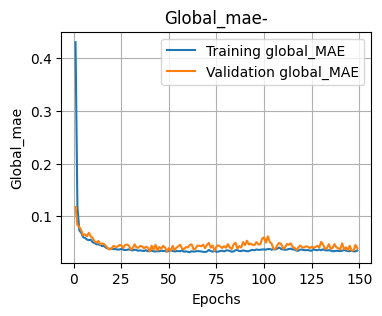

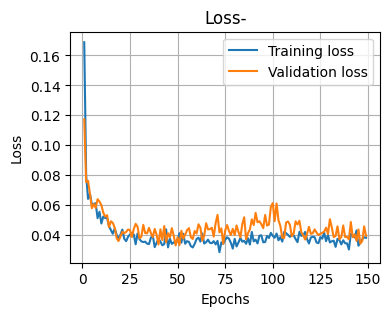

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

#   normalize
scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
#   testset (without mask and oversampling)
X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
# y_test  = val_df["Label"].to_numpy(dtype=np.int32)

# #  apply minority class oversampling to training and validation folds separately
# #  for learning curve analysis
# train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
# val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

#  generate mask
train_df.loc[:, 'Mask'] = train_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)
val_df.loc[:, 'Mask'] = val_df['CurrentNight'].apply(Gen_Mask, r=MASK_RATE)

#   extract X mask
X_train_nor, X_train_delta_nor = np.stack(train_df["Nor_X"].to_numpy()), np.stack(train_df['Nor_delta'])  # (N, T, F)
X_val_nor,   X_val_delta_nor   = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
X_mask = np.stack(train_df["Mask"].to_numpy())
X_val_mask = np.stack(val_df["Mask"].to_numpy())

# #   extract y
# Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
# Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


# ---------------- Stage 1: Reconstruction Model --------------------------------
# Instantiate autoencoder models
input_shape_li = [X_train_nor.shape[1:], X_train_delta_nor.shape[1:]]
print("input_shape_li:", input_shape_li)
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
# Compile and train autoencoder
training = MaskedReconstructionFit(autoencoder, alpha=1.0)
training.compile(optimizer=tf.optimizers.AdamW(1e-3, weight_decay=1e-4),
                #  metrics=[tf.keras.metrics.MeanAbsoluteError(name="global_MAE")]
                )
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    mode='min',
    patience=100,          # Number of epochs to wait before stopping if no improvement
    verbose=1,           # Prints a message when training stops
    restore_best_weights=True,  # Restores the weights from the best epoch
    min_delta=1e-6
)

# model_name = f'MAE_nontruma_Jul23_500epoach_Fold{fold}'
model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(MODEL_FOLDER_PRETRAIN, 'best_ae.keras'),
    save_best_only=True,  # Saves only the best model based on the monitored quantity
    monitor='val_loss',   # Quantity to monitor (e.g., validation loss)
    mode='min',           # 'min' for quantities like loss, 'max' for quantities like accuracy
    verbose=1             # Displays messages when a new best model is saved
)
history = training.fit((X_train_nor, X_train_delta_nor), X_mask,
                        validation_data=((X_val_nor, X_val_delta_nor), X_val_mask),
                        epochs=500, batch_size=128,
                        shuffle=True,
                        verbose=1,
                        callbacks=[model_checkpoint_callback,
                                    early_stopping
                                  ]       # Pass the callback here
                        )
# Save the model
save_models(encoders, autoencoder, save_dir=os.path.join(MODEL_FOLDER_PRETRAIN))

# Plot learning curves for the reconstruction model
plot_learning_curves(history)

# Evaluate reconstruction error
y_pred = autoencoder.predict([X_test_nor, X_delta_test_nor])
mae = tf.keras.metrics.MeanAbsoluteError(name="global_MAE")
mae.update_state(X_test_nor, y_pred)   # or simply  mae(X_test_nor, y_pred)
result = mae.result()                  # tf.Tensor scalar
print("MAE =", result.numpy())

## Evaluating

# New Section

In [ ]:
load_dir_path = MODEL_FOLDER_PRETRAIN = os.path.join(MODEL_FOLDER, 'MAE_UnifyTruma_Sep12_500epoach')
encoders, autoencoder = load_models(load_dir_path, load_autoencoder=True)

Autoencoder loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/MAE_UnifyTruma_Sep12_500epoach
Encoders loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/MAE_UnifyTruma_Sep12_500epoach


In [ ]:
# visualisation
import math
import matplotlib.pyplot as plt

def plot_reconstruction_subplots(
    sample_ori: np.ndarray,
    sample_hat: np.ndarray,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Reconstruction vs. Original"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compare original and reconstructed night-time series feature-by-feature.

    Parameters
    ----------
    sample_ori, sample_hat : (T, F) arrays  –– original & reconstructed
    feature_names          : list of F feature labels
    start_hour             : first x-axis hour label (default 18 → 18:00)
    ncols                  : number of subplot columns
    """
    T, F = sample_ori.shape
    assert sample_hat.shape == sample_ori.shape, "Shapes must match (T, F)"

    # hour labels
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # tidy DataFrames for optional inspection
    df_ori = pd.DataFrame(sample_ori, columns=feature_names, index=hour_labels)
    df_hat = pd.DataFrame(sample_hat, columns=feature_names, index=hour_labels)

    # subplot grid
    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, feat in enumerate(feature_names):
        ax = axes_flat[idx]
        ax.plot(range(T), df_ori[feat], label="Original",      linestyle="-")
        ax.plot(range(T), df_hat[feat], label="Reconstructed", linestyle="--")
        ax.set_ylabel(feat)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)
        ax.grid(True)

    # shared legend (upper-left, outside)
    ax.legend(["Original", "Reconstructed"],
              loc="upper left",
              fontsize="small",
              bbox_to_anchor=(1.02, 1),
              borderaxespad=0)

    # turn off any empty axes
    for ax in axes_flat[F:]:
        ax.axis("off")

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return


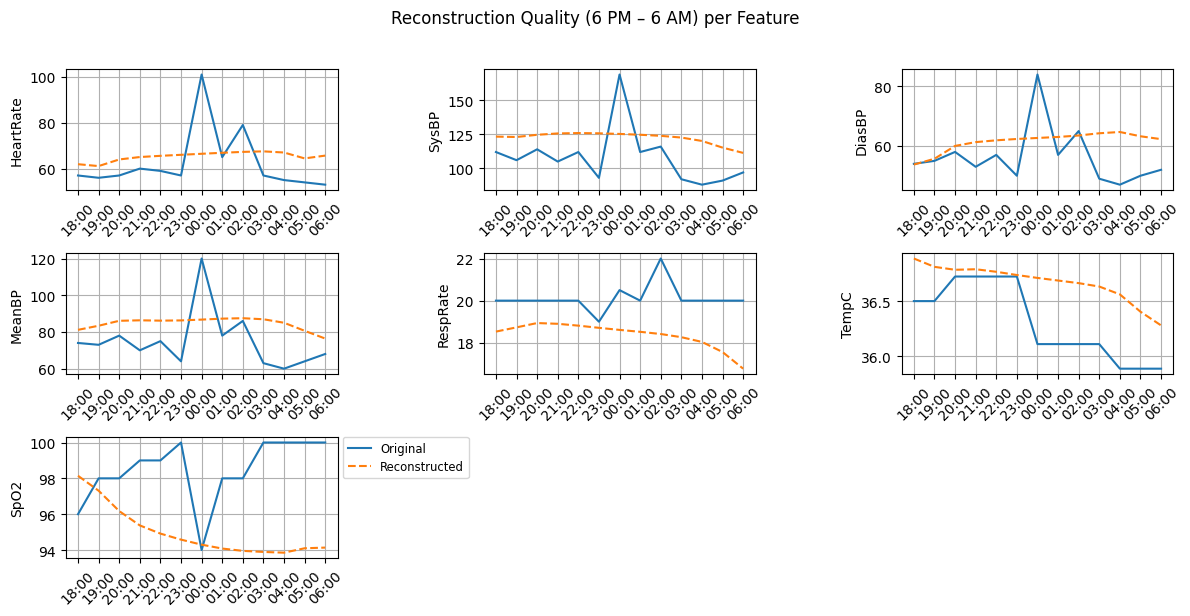

Sample-level MAE: 0.03475


In [ ]:
sample_idx   = 1

X_test = np.stack(val_df['CurrentNight'])
# de-normalise
X_hat =  denormalize_with_scaler(y_pred, scaler)

plot_reconstruction_subplots(
    X_test[sample_idx],
    X_hat[sample_idx],
    feature_names,
    start_hour=18,
    ncols=3,
    title_prefix="Reconstruction Quality (6 PM – 6 AM)"
)

# compute reconstruction loss
global_mae = mae.update_state(X_test_nor[sample_idx], X_test_nor[sample_idx])
print(f"Sample-level MAE: {mae.result():.5f}")